# Model selection and evaluation

## 1. Motivating example

<img src="fig/OverfittingUnderfitting.png">

Here, we are trying to find the relationship between size and price. To achieve this, we have taken the following steps:

- We’ve established the relationship using a linear equation for which the plots have been shown. The first plot has a high error from training data points. Therefore, this will not perform well on either public or the private leaderboard. This is an example of “Underfitting”. In this case, our model fails to capture the underlying trend of the data
- In the second plot, we just found the right relationship between price and size, i.e., low training error and generalization of the relationship
- In the third plot, we found a relationship which has almost zero training error. This is because the relationship is developed by considering each deviation in the data point (including noise), i.e., the model is too sensitive and captures random patterns which are present only in the current dataset. This is an example of “Overfitting”. In this relationship, there could be a high deviation between the public and private leaderboards

A common practice in data science competitions is to iterate over various models to find a better performing model. However, it becomes difficult to distinguish whether this improvement in score is coming because we are capturing the relationship better, or we are just over-fitting the data. To find the right answer for this question, we use validation techniques. This method helps us in achieving more generalized relationships.

## 2. Scoring parameter
Model selection and evaluation using tools, such as model_selection.GridSearchCV and model_selection.cross_val_score, take a scoring parameter that controls what metric they apply to the estimators evaluated.

### 2.1. Common cases: predefined values
For the most common use cases, you can designate a scorer object with the scoring parameter; the image below shows all possible values. All scorer objects follow the convention that higher return values are better than lower return values. Thus metrics which measure the distance between the model and the data, like metrics.mean_squared_error, are available as neg_mean_squared_error which return the negated value of the metric.
<img src="fig/SklearnEvaluationMetrics.png">

### 2.1 Using multiple metric evaluation
Scikit-learn also permits evaluation of multiple metrics in GridSearchCV, RandomizedSearchCV and cross_validate.

There are two ways to specify multiple scoring metrics for the scoring parameter:

As an iterable of string metrics:
    - scoring = ['accuracy', 'precision']
As a dict mapping the scorer name to the scoring function:
    - from sklearn.metrics import accuracy_score
    - from sklearn.metrics import make_scorer
    - scoring = {'accuracy': make_scorer(accuracy_score), 'prec': 'precision'}
Note that the dict values can either be scorer functions or one of the predefined metric strings.

Currently only those scorer functions that return a single score can be passed inside the dict. Scorer functions that return multiple values are not permitted and will require a wrapper to return a single metric:

In [1]:
from sklearn.model_selection import cross_validate
from sklearn.metrics import confusion_matrix
from sklearn import datasets
from sklearn.svm import LinearSVC
# A sample toy binary classification dataset
X, y = datasets.make_classification(n_classes=2, random_state=0)
svm = LinearSVC(random_state=0)
scoring = {'accuracy': 'accuracy', 'prec': 'precision'}
cv_results = cross_validate(svm.fit(X, y), X, y,
                            scoring=scoring, cv=5)

print(cv_results)  


{'fit_time': array([0.00106406, 0.00141907, 0.00126028, 0.00140142, 0.00115085]), 'score_time': array([0.00087905, 0.00077224, 0.00076151, 0.00077105, 0.00076246]), 'test_accuracy': array([0.75, 0.9 , 0.8 , 0.65, 0.9 ]), 'test_prec': array([0.66666667, 0.9       , 0.8       , 0.63636364, 1.        ])}


## 3. Evaluating estimator performance
Learning the parameters of a prediction function and testing it on the same data is a methodological mistake: a model that would just repeat the labels of the samples that it has just seen would have a perfect score but would fail to predict anything useful on yet-unseen data. This situation is called __overfitting__. To avoid it, it is common practice when performing a (supervised) machine learning experiment to hold out part of the available data as a test set X_test, y_test. 

In scikit-learn a random split into training and test sets can be quickly computed with the train_test_split helper function. Let’s load the iris data set to fit a linear support vector machine on it:

In [2]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn import datasets
from sklearn import svm

iris = datasets.load_iris()
iris.data.shape, iris.target.shape

((150, 4), (150,))

We can now quickly sample a training set while holding out 40% of the data for testing (evaluating) our classifier:

In [3]:
X_train, X_test, y_train, y_test = train_test_split(
    iris.data, iris.target, test_size=0.4, random_state=0)

print(X_train.shape, y_train.shape)

print(X_test.shape, y_test.shape)


clf = svm.SVC(kernel='linear', C=1).fit(X_train, y_train)
print(clf.predict(X_test))
print(clf.score(X_test, y_test)  )

(90, 4) (90,)
(60, 4) (60,)
[2 1 0 2 0 2 0 1 1 1 2 1 1 1 1 0 1 1 0 0 2 1 0 0 1 0 0 1 1 0 2 1 0 2 2 1 0
 2 1 1 2 0 2 0 0 1 2 2 2 2 1 2 1 1 2 2 2 2 1 2]
0.9666666666666667


When evaluating different settings (“hyperparameters”) for estimators, such as the C setting that must be manually set for an SVM, there is still a risk of overfitting on the test set because the parameters can be tweaked until the estimator performs optimally. This way, knowledge about the test set can “leak” into the model and evaluation metrics no longer report on generalization performance. To solve this problem, yet another part of the dataset can be held out as a so-called “validation set”: training proceeds on the training set, after which evaluation is done on the validation set, and when the experiment seems to be successful, final evaluation can be done on the test set.

However, by partitioning the available data into three sets, we drastically reduce the number of samples which can be used for learning the model, and the results can depend on a particular random choice for the pair of (train, validation) sets.

A solution to this problem is a procedure called cross-validation (CV for short). A test set should still be held out for final evaluation, but the validation set is no longer needed when doing CV. In the basic approach, called k-fold CV, the training set is split into k smaller sets (other approaches are described below, but generally follow the same principles). The following procedure is followed for each of the k “folds”:

- A model is trained using  of the folds as training data;
- the resulting model is validated on the remaining part of the data (i.e., it is used as a test set to compute a performance measure such as accuracy).
The performance measure reported by k-fold cross-validation is then the average of the values computed in the loop. This approach can be computationally expensive, but does not waste too much data (as is the case when fixing an arbitrary validation set), which is a major advantage in problems such as inverse inference where the number of samples is very small.

<img src="fig/KFoldCrossValidation.png">

### 3.1. Computing cross-validated metrics
The simplest way to use cross-validation is to call the cross_val_score helper function on the estimator and the dataset.

The following example demonstrates how to estimate the accuracy of a linear kernel support vector machine on the iris dataset by splitting the data, fitting a model and computing the score 5 consecutive times (with different splits each time):

In [4]:
from sklearn.model_selection import cross_val_score
clf = svm.SVC(kernel='linear', C=1)
scores = cross_val_score(clf, iris.data, iris.target, cv=10)
print(scores)

[1.         0.93333333 1.         1.         0.86666667 1.
 0.93333333 1.         1.         1.        ]


The mean score and the 95% confidence interval of the score estimate are hence given by:

In [5]:
print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

Accuracy: 0.97 (+/- 0.09)


By default, the score computed at each CV iteration is the score method of the estimator. It is possible to change this by using the scoring parameter:

In [6]:
from sklearn import metrics
scores = cross_val_score(
    clf, iris.data, iris.target, cv=5, scoring='f1_macro')
print(scores)

[0.96658312 1.         0.96658312 0.96658312 1.        ]


In [7]:
scores.mean()

0.9799498746867169

In the case of the Iris dataset, the samples are balanced across target classes hence the accuracy and the F1-score are almost equal. It is also possible to use other cross validation strategies by passing a cross validation iterator instead, for instance:

In [8]:
from sklearn.model_selection import ShuffleSplit
n_samples = iris.data.shape[0]
cv = ShuffleSplit(n_splits=5, test_size=0.3, random_state=0)
cross_val_score(clf, iris.data, iris.target, cv=cv)

array([0.97777778, 0.97777778, 1.        , 0.95555556, 1.        ])

##### Data transformation with held out data

Just as it is important to test a predictor on data held-out from training, preprocessing (such as standardization, feature selection, etc.) and similar data transformations similarly should be learnt from a training set and applied to held-out data for prediction:

In [9]:
from sklearn import preprocessing
X_train, X_test, y_train, y_test = train_test_split(
    iris.data, iris.target, test_size=0.4, random_state=0)

scaler = preprocessing.StandardScaler().fit(X_train)
X_train_transformed = scaler.transform(X_train)

clf = svm.SVC(C=1).fit(X_train_transformed, y_train)

X_test_transformed = scaler.transform(X_test)
clf.score(X_test_transformed, y_test)

0.9333333333333333

#### 3.1.1. The cross_validate function and multiple metric evaluation
The cross_validate function differs from cross_val_score in two ways:

- It allows specifying multiple metrics for evaluation.
- It returns a dict containing fit-times, score-times (and optionally training scores as well as fitted estimators) in addition to the test score.
For single metric evaluation, where the scoring parameter is a string, callable or None, the keys will be ['test_score', 'fit_time', 'score_time']

And for multiple metric evaluation, the return value is a dict with the following keys ['test_<scorer1_name>', 'test_<scorer2_name>', 'test_<scorer...>', 'fit_time', 'score_time']

return_train_score is set to False by default to save computation time. To evaluate the scores on the training set as well you need to be set to True.

You may also retain the estimator fitted on each training set by setting return_estimator=True.

The multiple metrics can be specified either as a list, tuple or set of predefined scorer names:

In [10]:
from sklearn.model_selection import cross_validate
from sklearn.metrics import recall_score
scoring = ['precision_macro', 'recall_macro','accuracy']
clf = svm.SVC(kernel='linear', C=1, random_state=0)
scores = cross_validate(clf, iris.data, iris.target, scoring=scoring,
                        cv=5)
print(sorted(scores.keys()))

print(scores['test_recall_macro'])

['fit_time', 'score_time', 'test_accuracy', 'test_precision_macro', 'test_recall_macro']
[0.96666667 1.         0.96666667 0.96666667 1.        ]


In [11]:
scores

{'fit_time': array([0.00120616, 0.00101662, 0.00089622, 0.00094056, 0.00089931]),
 'score_time': array([0.0022943 , 0.00232959, 0.00232768, 0.00219727, 0.00220895]),
 'test_precision_macro': array([0.96969697, 1.        , 0.96969697, 0.96969697, 1.        ]),
 'test_recall_macro': array([0.96666667, 1.        , 0.96666667, 0.96666667, 1.        ]),
 'test_accuracy': array([0.96666667, 1.        , 0.96666667, 0.96666667, 1.        ])}

Here is an example of cross_validate using a single metric:

In [12]:
scores = cross_validate(clf, iris.data, iris.target,
                        scoring='precision_macro', cv=5,
                        return_estimator=True)
print(sorted(scores.keys()))


['estimator', 'fit_time', 'score_time', 'test_score']


In [13]:
scores

{'fit_time': array([0.00121498, 0.00079012, 0.00088358, 0.00099468, 0.00060606]),
 'score_time': array([0.00087237, 0.00070357, 0.00098991, 0.00061584, 0.00058055]),
 'estimator': (SVC(C=1, cache_size=200, class_weight=None, coef0=0.0,
      decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
      kernel='linear', max_iter=-1, probability=False, random_state=0,
      shrinking=True, tol=0.001, verbose=False),
  SVC(C=1, cache_size=200, class_weight=None, coef0=0.0,
      decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
      kernel='linear', max_iter=-1, probability=False, random_state=0,
      shrinking=True, tol=0.001, verbose=False),
  SVC(C=1, cache_size=200, class_weight=None, coef0=0.0,
      decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
      kernel='linear', max_iter=-1, probability=False, random_state=0,
      shrinking=True, tol=0.001, verbose=False),
  SVC(C=1, cache_size=200, class_weight=None, coef0=0.0,
      decision_fu

### 3.2. Cross validation iterators
The following sections list utilities to generate indices that can be used to generate dataset splits according to different cross validation strategies.
Assuming that some data is Independent and Identically Distributed (i.i.d.) is making the assumption that all samples stem from the same generative process and that the generative process is assumed to have no memory of past generated samples.

The following cross-validators can be used in such cases.

#### 3.2.1 K-fold
KFold divides all the samples in $k$ groups of samples, called folds (if $k=n$, this is equivalent to the Leave One Out strategy), of equal sizes (if possible). The prediction function is learned using $k-1$ folds, and the fold left out is used for test.

Example of 2-fold cross-validation on a dataset with 4 samples:

In [14]:
import numpy as np
from sklearn.model_selection import KFold

X = ["a", "b", "c", "d"]
kf = KFold(n_splits=2)
for train, test in kf.split(X):
    print("%s %s" % (train, test))

[2 3] [0 1]
[0 1] [2 3]


Here is a visualization of the cross-validation behavior. Note that KFold is not affected by classes or groups.

<img src="fig/KFold1.png">

In [15]:
kf = KFold(n_splits=10)
for train, test in kf.split(iris.data):
    print("%s %s" % (train, test))

[ 15  16  17  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32
  33  34  35  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50
  51  52  53  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68
  69  70  71  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86
  87  88  89  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104
 105 106 107 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122
 123 124 125 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140
 141 142 143 144 145 146 147 148 149] [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14]
[  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  30  31  32
  33  34  35  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50
  51  52  53  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68
  69  70  71  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86
  87  88  89  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104
 105 106 107 108 109 110 111 112 113 11

In [16]:
from sklearn.naive_bayes import GaussianNB
model = GaussianNB()
results = cross_val_score(model, iris.data, iris.target, cv=kf, scoring='accuracy')
results.mean()

0.9466666666666667

#### 3.2.2 Repeated K-fold
RepeatedKFold repeats K-Fold n times. It can be used when one requires to run KFold n times, producing different splits in each repetition.

Example of 2-fold K-Fold repeated 2 times:

In [ ]:
import numpy as np
from sklearn.model_selection import RepeatedKFold
X = np.array([[1, 2], [3, 4], [1, 2], [3, 4]])
random_state = 12883823
rkf = RepeatedKFold(n_splits=2, n_repeats=2, random_state=random_state)
for train, test in rkf.split(X):
    print("%s %s" % (train, test))

In [ ]:
rkf = RepeatedKFold(n_splits=10, n_repeats=2, random_state=random_state)
for train, test in rkf.split(iris.data):
    print("%s %s" % (train, test))

In [ ]:
from sklearn.naive_bayes import GaussianNB
model = GaussianNB()
results = cross_val_score(model, iris.data, iris.target, cv=rkf, scoring='accuracy')
results.mean()

#### 3.2.3 Leave One Out (LOO)
LeaveOneOut (or LOO) is a simple cross-validation. Each learning set is created by taking all the samples except one, the test set being the sample left out. Thus, for  samples, we have  different training sets and  different tests set. This cross-validation procedure does not waste much data as only one sample is removed from the training set:

In [ ]:
from sklearn.model_selection import LeaveOneOut

X = [1, 2, 3, 4]
loo = LeaveOneOut()
for train, test in loo.split(X):
    print("%s %s" % (train, test))

Potential users of LOO for model selection should weigh a few known caveats. When compared with k-fold cross validation, one builds $n$ models from $n$ samples instead of $k$ models, where $n>k$. Moreover, each is trained on $n-1$ samples rather than $(k-1)n/k$. In both ways, assuming $k$ is not too large and $k<n$, LOO is more computationally expensive than k-fold cross validation.

In terms of accuracy, LOO often results in high variance as an estimator for the test error. Intuitively, since $n-1$ of the $n$ samples are used to build each model, models constructed from folds are virtually identical to each other and to the model built from the entire training set.

However, if the learning curve is steep for the training size in question, then 5- or 10- fold cross validation can overestimate the generalization error.

As a general rule, most authors, and empirical evidence, suggest that 5- or 10- fold cross validation should be preferred to LOO.

In [ ]:
from sklearn.naive_bayes import GaussianNB
loIris=LeaveOneOut()
model = GaussianNB()
results = cross_val_score(model, iris.data, iris.target, cv=loIris, scoring='accuracy')
results.mean()

In [ ]:
len(results)

#### 3.2.4 Leave P Out (LPO)
LeavePOut is very similar to LeaveOneOut as it creates all the possible training/test sets by removing $p$ samples from the complete set. For $n$ samples, this produces $\binom{n}{p}$ train-test pairs. Unlike LeaveOneOut and KFold, the test sets will overlap for $p>1$. Example of Leave-2-Out on a dataset with 4 samples:

In [ ]:
from sklearn.model_selection import LeavePOut

X = np.ones(4)
lpo = LeavePOut(p=2)
for train, test in lpo.split(X):
    print("%s %s" % (train, test))

In [ ]:
from sklearn.naive_bayes import GaussianNB
loIris=LeavePOut(p=2)
model = GaussianNB()
results = cross_val_score(model, iris.data, iris.target, cv=loIris, scoring='accuracy')
results.mean()

In [ ]:
len(results)

#### 3.2.5 Random permutations cross-validation a.k.a. Shuffle & Split
The ShuffleSplit iterator will generate a user defined number of independent train / test dataset splits. Samples are first shuffled and then split into a pair of train and test sets.

It is possible to control the randomness for reproducibility of the results by explicitly seeding the random_state pseudo random number generator.

Here is a usage example:

In [ ]:
from sklearn.model_selection import ShuffleSplit
X = np.arange(10)
ss = ShuffleSplit(n_splits=5, test_size=0.25,
    random_state=0)
for train_index, test_index in ss.split(X):
    print("%s %s" % (train_index, test_index))

Here is a visualization of the cross-validation behavior. Note that ShuffleSplit is not affected by classes or groups.

<img src="fig/ShuffleSplit.png">

ShuffleSplit is thus a good alternative to KFold cross validation that allows a finer control on the number of iterations and the proportion of samples on each side of the train / test split.

#### 3.2.6 Cross-validation iterators with stratification based on class labels
Some classification problems can exhibit a large imbalance in the distribution of the target classes: for instance there could be several times more negative samples than positive samples. In such cases it is recommended to use stratified sampling as implemented in StratifiedKFold and StratifiedShuffleSplit to ensure that relative class frequencies is approximately preserved in each train and validation fold.

##### 3.2.6.1 StratifiedKFold
StratifiedKFold is a variation of k-fold which returns stratified folds: each set contains approximately the same percentage of samples of each target class as the complete set.

Example of stratified 3-fold cross-validation on a dataset with 10 samples from two slightly unbalanced classes:

In [ ]:
from sklearn.model_selection import StratifiedKFold

X = np.ones(10)
y = [0, 0, 0, 0, 1, 1, 1, 1, 1, 1]
skf = StratifiedKFold(n_splits=3)
for train, test in skf.split(X, y):
    print("%s %s" % (train, test))

Here is a visualization of the cross-validation behavior.

<img src="fig/StratifiedKFold.png">

RepeatedStratifiedKFold can be used to repeat Stratified K-Fold n times with different randomization in each repetition.

## 4. Classification metrics
The sklearn.metrics module implements several loss, score, and utility functions to measure classification performance. Some metrics might require probability estimates of the positive class, confidence values, or binary decisions values. Most implementations allow each sample to provide a weighted contribution to the overall score, through the sample_weight parameter.
<img src="fig/ClassificationMetricsSklearn.png">

### 4.1 From binary to multiclass and multilabel
Some metrics are essentially defined for binary classification tasks (e.g. f1_score, roc_auc_score). In these cases, by default only the positive label is evaluated, assuming by default that the positive class is labelled 1 (though this may be configurable through the pos_label parameter).

In extending a binary metric to multiclass or multilabel problems, the data is treated as a collection of binary problems, one for each class. There are then a number of ways to average binary metric calculations across the set of classes, each of which may be useful in some scenario. Where available, you should select among these using the average parameter.

- "macro" simply calculates the mean of the binary metrics, giving equal weight to each class. In problems where infrequent classes are nonetheless important, macro-averaging may be a means of highlighting their performance. On the other hand, the assumption that all classes are equally important is often untrue, such that macro-averaging will over-emphasize the typically low performance on an infrequent class.
- "weighted" accounts for class imbalance by computing the average of binary metrics in which each class’s score is weighted by its presence in the true data sample.
- "micro" gives each sample-class pair an equal contribution to the overall metric (except as a result of sample-weight). Rather than summing the metric per class, this sums the dividends and divisors that make up the per-class metrics to calculate an overall quotient. Micro-averaging may be preferred in multilabel settings, including multiclass classification where a majority class is to be ignored.

### 4.2 Some basic terms
Before diving in the main evaluation metrics lets understand the terms that form the basis for these.

- True Positive (TP - actual = 1, predicted = 1): Label which was predicted Positive and is actually Positive.
- True Negative (TN - actual = 0, predicted = 0): Label which was predicted Negative and is actually Negative.
- False Positive (FP - actual = 0, predicted = 1): Label which was predicted as Positive, but is actually Negative.
- False Negative (FN - actual = 1, predicted = 0): Label which was predicted as Negative, but is actually Positive. 
    
<img src="fig/ConfusionMatrixSklearn.png">
<img src="fig/ConfusionMatrixSklearn1.png">

### 4.3. Accuracy score
The most common metric for classification is accuracy, which is the fraction of samples predicted correctly. In Sklearn the accuracy is computed by the function accuracy_score, which can produce either the fraction (default) or the count (normalize=False) of correct predictions.

In multilabel classification, the function returns the subset accuracy. If the entire set of predicted labels for a sample strictly match with the true set of labels, then the subset accuracy is 1.0; otherwise it is 0.0.

If $\hat{y_i}$ is the predicted value of the i-th sample and $y_i$ is the corresponding true value, then the fraction of correct predictions over $n_{samples}$ is defined as

$$accuracy(y_i, \hat{y_i}) = \frac{1}{n_{samples}} \sum_{i=0}^{n_{samples}-1} 1(y_i = \hat{y_i})$$

where $1(x)$ is the indicator function.
<img src="fig/AccuracySklearn.png">

In [ ]:
import numpy as np
from sklearn.metrics import accuracy_score
y_pred = [0, 2, 1, 3]
y_true = [0, 1, 2, 3]
print(accuracy_score(y_true, y_pred))
print(accuracy_score(y_true, y_pred, normalize=False))

### 4.4 Does accuracy matter?
Is accuracy an always effective evaluation measure? No! Accuracy is not always the best metric to use to assess classification models. For example, let’s say that we are trying to predict something that only happens 1 out of 100 times. We could build a model that gets 99% accuracy by saying the event never happened. However, we catch 0% of the events we care about. This aspect is particularly critical when your target class is not balanced (data is skewed). 

### 4.5 Precision
It is the ‘Exactness’, ability of the model to return only relevant instances. If your use case/problem statement involves minimizing the False Positives then Precision is something you need.

$$ Precision = \frac{TP}{TP+FP} $$

<img src="fig/PrecisionSklearn.png">

### 4.6 Recall
It is the ‘Completeness’, ability of the model to identify all relevant instances, True Positive Rate, aka Sensitivity.

$$ Recall = \frac{TP}{TP+FN} $$

<img src="fig/RecallSklearn.png">

One method to boost the recall is to increase the number of samples that you define as predicted positive by lowering the threshold for predicted positive. Unfortunately, this will also increase the number of false positives. 

### 4.7 F1 score
What would you do if one model was better at recall and the other was better at precision? One method that some data scientists use is called the F1 score.
The f1 score is the harmonic mean of recall and precision, with a higher score as a better model. The f1 score is calculated using the following formula:

$$ F_1 = \frac{2}{\frac{1}{precision} + \frac{1}{recall}} = \frac{2*precision*recall}{precision + recall} $$

F1 Score reaches its best value at 1 (perfect precision and recall) and worst at 0.

### 4.8 F-beta score
It is the general form of F measure. Beta equals to 0.5 or 2 are usually used as measures; 0.5 indicates the Inclination towards Precision whereas 2 favors Recall giving it twice the weightage compared to precision.

$$ F_\beta = \frac{(1+\beta^2)*precision*recall}{\beta^2*precision + recall} $$

### 4.9 Specificity
It is also referred to as ‘True Negative Rate’ (Proportion of actual negatives that are correctly identified), i.e. more True Negatives the data hold the higher its Specificity.

$$ Specificity = \frac{TN}{TN+FP} $$

### 4.10 Multiclass classification
In multiclass and multilabel classification task, the notions of precision, recall, and F-measures can be applied to each label independently. There are a few ways to combine results across labels, specified by the average argument to the average_precision_score (multilabel only), f1_score, fbeta_score, precision_recall_fscore_support, precision_score and recall_score functions, as described above. Note that if all labels are included, “micro”-averaging in a multiclass setting will produce precision, recall and $F$ that are all identical to accuracy. Also note that “weighted” averaging may produce an F-score that is not between precision and recall.

<img src="fig/MulticlassClassification.png">

In [ ]:
from sklearn import metrics
y_true = [0, 1, 2, 0, 1, 2]
y_pred = [0, 2, 1, 0, 0, 1]
print(metrics.precision_score(y_true, y_pred, average='macro'))

print(metrics.recall_score(y_true, y_pred, average='micro'))

print(metrics.f1_score(y_true, y_pred, average='weighted'))  

print(metrics.fbeta_score(y_true, y_pred, average='macro', beta=0.5))

print(metrics.precision_recall_fscore_support(y_true, y_pred, beta=0.5, average=None))

### 4.11 Confusion matrix
A confusion matrix is a summary of prediction results on a classification problem. The number of correct and incorrect predictions are summarized with count values and broken down by each class. This is the key to the confusion matrix. 

The confusion matrix shows the ways in which your classification model is confused when it makes predictions. 

It gives you insight not only into the errors being made by your classifier but more importantly the types of errors that are being made.

By definition, entry $i,j$ in a confusion matrix is the number of observations actually in group $i$, but predicted to be in group $j$. Here is an example:

In [ ]:
from sklearn.metrics import confusion_matrix
y_true = [2, 0, 2, 2, 0, 1]
y_pred = [0, 0, 2, 2, 0, 2]
confusion_matrix(y_true, y_pred)

#### Example
Example of confusion matrix usage to evaluate the quality of the output of a classifier on the iris data set. The diagonal elements represent the number of points for which the predicted label is equal to the true label, while off-diagonal elements are those that are mislabeled by the classifier. The higher the diagonal values of the confusion matrix the better, indicating many correct predictions.

The figures show the confusion matrix with and without normalization by class support size (number of elements in each class). This kind of normalization can be interesting in case of class imbalance to have a more visual interpretation of which class is being misclassified.

Here the results are not as good as they could be as our choice for the regularization parameter C was not the best.

Confusion matrix, without normalization
[[13  0  0]
 [ 0 10  6]
 [ 0  0  9]]
Normalized confusion matrix
[[1.   0.   0.  ]
 [0.   0.62 0.38]
 [0.   0.   1.  ]]


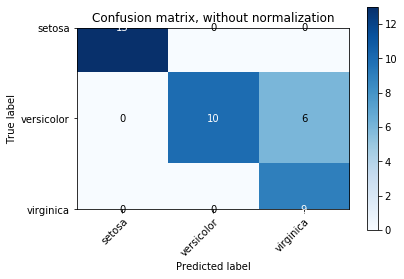

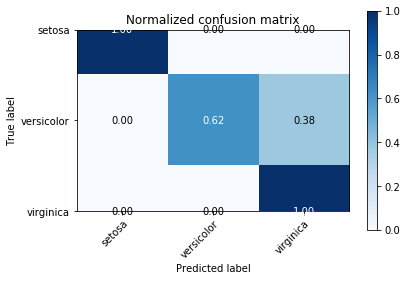

In [2]:
import numpy as np
import matplotlib.pyplot as plt

from sklearn import svm, datasets
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels

# import some data to play with
iris = datasets.load_iris()
X = iris.data
y = iris.target
class_names = iris.target_names

# Split the data into a training set and a test set
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

# Run classifier, using a model that is too regularized (C too low) to see
# the impact on the results
classifier = svm.SVC(kernel='linear', C=0.01)
y_pred = classifier.fit(X_train, y_train).predict(X_test)


def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    classes = classes[unique_labels(y_true, y_pred)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax


np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plot_confusion_matrix(y_test, y_pred, classes=class_names,
                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plot_confusion_matrix(y_test, y_pred, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')

plt.show()

For binary problems, we can get counts of true negatives, false positives, false negatives and true positives as follows:

In [ ]:
y_true = [0, 0, 0, 1, 1, 1, 1, 1]
y_pred = [0, 1, 0, 1, 0, 1, 0, 1]
tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
tn, fp, fn, tp

The multilabel_confusion_matrix function computes class-wise (default) or sample-wise (samplewise=True) multilabel confusion matrix to evaluate the accuracy of a classification. multilabel_confusion_matrix also treats multiclass data as if it were multilabel, as this is a transformation commonly applied to evaluate multiclass problems with binary classification metrics (such as precision, recall, etc.).

When calculating class-wise multilabel confusion matrix $C$, the count of true negatives for class $i$ is $C_{i,0,0}$, false negatives is $C_{i,1,0}$, true positives is $C_{i,1,1}$ and false positives is $C_{i,0,1}$.

Here is an example demonstrating the use of the multilabel_confusion_matrix function with multiclass input:

In [ ]:
y_true = ["cat", "ant", "cat", "cat", "ant", "bird"]
y_pred = ["ant", "ant", "cat", "cat", "ant", "cat"]
multilabel_confusion_matrix(y_true, y_pred,
                            labels=["ant", "bird", "cat"])

### 4.12. Classification report
The classification_report function builds a text report showing the main classification metrics. Here is a small example with custom target_names and inferred labels:

In [ ]:
from sklearn.metrics import classification_report
y_true = [0, 1, 2, 2, 0]
y_pred = [0, 0, 2, 1, 0]
target_names = ['class 0', 'class 1', 'class 2']
print(classification_report(y_true, y_pred, target_names=target_names))

## 5. Regression metrics
The sklearn.metrics module implements several loss, score, and utility functions to measure regression performance. 

### 5.1 Explained variance score
The explained_variance_score computes the explained variance regression score.

If $\hat{y}$ is the estimated target output, $y$ the corresponding (correct) target output, and $Var$ is Variance, the square of the standard deviation, then the explained variance is estimated as follow:

$$ explained\_variance(\hat{y}, y) = 1 - \frac{Var\{y - \hat{y}\}}{Var\{y\}} $$

The best possible score is 1.0, lower values are worse.

In [ ]:
from sklearn.metrics import explained_variance_score
y_true = [3, -0.5, 2, 7]
y_pred = [2.5, 0.0, 2, 8]
print(explained_variance_score(y_true, y_pred))

### 5.2 Max error
The max_error function computes the maximum residual error , a metric that captures the worst case error between the predicted value and the true value. In a perfectly fitted single output regression model, max_error would be 0 on the training set and though this would be highly unlikely in the real world, this metric shows the extent of error that the model had when it was fitted.

If $\hat{y_i}$ is the predicted value of the i-th sample, and $y_i$ is the corresponding true value, then the max error is defined as:

$$ MaxError(\hat{y}, y) = max(|y_i-\hat{y_i}|) $$



In [ ]:
from sklearn.metrics import max_error
y_true = [3, 2, 7, 1]
y_pred = [9, 2, 7, 1]
max_error(y_true, y_pred)

### 5.3 Mean Absolute Error
The mean_absolute_error function computes mean absolute error, a risk metric corresponding to the expected value of the absolute error loss or l1-norm loss.

If $\hat{y_i}$ is the predicted value of the i-th sample, and $y_i$ is the corresponding true value, then the mean absolute error (MAE) estimated over $n_{samples}$ is defined as:

$$ MAE(y, \hat{y}) = \frac{1}{n_{samples}} \sum_{i=0}^{n_{samples}} |y_{i}-\hat{y_{i}}| $$

In [ ]:
from sklearn.metrics import mean_absolute_error
y_true = [3, -0.5, 2, 7]
y_pred = [2.5, 0.0, 2, 8]
mean_absolute_error(y_true, y_pred)

### 5.4 Mean Squared Error
The mean_squared_error function computes mean square error, a risk metric corresponding to the expected value of the squared (quadratic) error or loss.

If $\hat{y_i}$ is the predicted value of the i-th sample, and $y_i$ is the corresponding true value, then the mean squared error (MSE) estimated over $n_{samples}$ is defined as:

$$ MSE(y, \hat{y}) = \frac{1}{n_{samples}} \sum_{i=0}^{n_{samples}} (y_{i}-\hat{y_{i}})^2 $$

In [ ]:
from sklearn.metrics import mean_squared_error
y_true = [3, -0.5, 2, 7]
y_pred = [2.5, 0.0, 2, 8]
mean_squared_error(y_true, y_pred)

##### 5.5 Mean Squared Logarithmic Error
The mean_squared_log_error function computes a risk metric corresponding to the expected value of the squared logarithmic (quadratic) error or loss.

If $\hat{y_i}$ is the predicted value of the i-th sample, and $y_i$ is the corresponding true value, then the mean squared logarithmic error (MSLE) estimated over $n_{samples}$ is defined as:

$$ MSLE(y, \hat{y}) = \frac{1}{n_{samples}} \sum_{i=0}^{n_{samples}} (log_e(1+y_{i})-log_e(1+\hat{y_{i}}))^2 $$

Where $log_e(x)$ means the natural logarithm of $x$. This metric is best to use when targets having exponential growth, such as population counts, average sales of a commodity over a span of years etc. Note that this metric penalizes an under-predicted estimate greater than an over-predicted estimate.

In [ ]:
from sklearn.metrics import mean_squared_log_error
y_true = [3, 5, 2.5, 7]
y_pred = [2.5, 5, 4, 8]
mean_squared_log_error(y_true, y_pred)

##### 5.6 Median Absolute Error
The median_absolute_error is particularly interesting because it is robust to outliers. The loss is calculated by taking the median of all absolute differences between the target and the prediction.

If $\hat{y_i}$ is the predicted value of the i-th sample, and $y_i$ is the corresponding true value, then the median absolute error (MedAE) estimated over $n_{samples}$ is defined as:

$$ MedAE(y, \hat{y}) = median(|y_{1}-\hat{y_{1}}|, ..., |y_{n}-\hat{y_{n}}|) $$

In [ ]:
from sklearn.metrics import median_absolute_error
y_true = [3, -0.5, 2, 7]
y_pred = [2.5, 0.0, 2, 8]
median_absolute_error(y_true, y_pred)

### 5.7 R² score, the coefficient of determination
The r2_score function computes the coefficient of determination, usually denoted as R².

It represents the proportion of variance (of y) that has been explained by the independent variables in the model. It provides an indication of goodness of fit and therefore a measure of how well unseen samples are likely to be predicted by the model, through the proportion of explained variance.

As such variance is dataset dependent, R² may not be meaningfully comparable across different datasets. Best possible score is 1.0 and it can be negative (because the model can be arbitrarily worse). A constant model that always predicts the expected value of y, disregarding the input features, would get a R² score of 0.0.

If $\hat{y_i}$ is the predicted value of the i-th sample, and $y_i$ is the corresponding true value for total $n$ samples, the estimated $R^2$ is defined:

$$ R^2(y, \hat{y}) = 1-\frac{\sum_{i=0}^{n}(y_i-\hat{y_i})^2}{Var\{y\}} $$

In [ ]:
from sklearn.metrics import r2_score
y_true = [3, -0.5, 2, 7]
y_pred = [2.5, 0.0, 2, 8]
r2_score(y_true, y_pred) 

## 6. Dummy estimators
When doing supervised learning, a simple sanity check consists of comparing one’s estimator against simple rules of thumb. DummyClassifier implements several such simple strategies for classification:

- stratified generates random predictions by respecting the training set class distribution.
- most_frequent always predicts the most frequent label in the training set.
- uniform generates predictions uniformly at random.
- constant always predicts a constant label that is provided by the user.
A major motivation of this method is F1-scoring, when the positive class is in the minority.

Note that with all these strategies, the predict method completely ignores the input data!

To illustrate DummyClassifier, first let’s create an imbalanced dataset:

In [ ]:
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
iris = load_iris()
X, y = iris.data, iris.target
y[y != 1] = -1
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

Next, let’s compare the accuracy of SVC and most_frequent

In [ ]:
from sklearn.dummy import DummyClassifier
from sklearn.svm import SVC
clf = SVC(kernel='linear', C=1).fit(X_train, y_train)
print(clf.score(X_test, y_test))

clf = DummyClassifier(strategy='most_frequent', random_state=0)
clf.fit(X_train, y_train)
print(clf.score(X_test, y_test))

We see that SVC doesn’t do much better than a dummy classifier. Now, let’s change the kernel:

In [ ]:
clf = SVC(gamma='scale', kernel='rbf', C=1).fit(X_train, y_train)
clf.score(X_test, y_test)

We see that the accuracy was boosted to almost 100%. A cross validation strategy is recommended for a better estimate of the accuracy, if it is not too CPU costly.

More generally, when the accuracy of a classifier is too close to random, it probably means that something went wrong: features are not helpful, a hyperparameter is not correctly tuned, the classifier is suffering from class imbalance, etc…

DummyRegressor also implements four simple rules of thumb for regression:

    - mean always predicts the mean of the training targets.
    - median always predicts the median of the training targets.
    - quantile always predicts a user provided quantile of the training targets.
    - constant always predicts a constant value that is provided by the user.
In all these strategies, the predict method completely ignores the input data.

## 7. Tuning the hyper-parameters of an estimator
Hyper-parameters are parameters that are not directly learnt within estimators. In scikit-learn they are passed as arguments to the constructor of the estimator classes.
It is possible and recommended to search the hyper-parameter space for the best cross validation score.

Any parameter provided when constructing an estimator may be optimized in this manner. Specifically, to find the names and current values for all parameters for a given estimator, use __estimator.get_params()__.
A search consists of:

- an estimator (regressor or classifier such as sklearn.svm.SVC());
- a parameter space;
- a method for searching or sampling candidates;
- a cross-validation scheme; and
- a score function.
    
Some models allow for specialized, efficient parameter search strategies, outlined below. Two generic approaches to sampling search candidates are provided in scikit-learn: for given values, GridSearchCV exhaustively considers all parameter combinations, while RandomizedSearchCV can sample a given number of candidates from a parameter space with a specified distribution. After describing these tools we detail best practice applicable to both approaches.

### 7.1 Exhaustive Grid Search
The grid search provided by GridSearchCV exhaustively generates candidates from a grid of parameter values specified with the param_grid parameter. For instance, the following param_grid:

param_grid = [
  {'C': [1, 10, 100, 1000], 'kernel': ['linear']},
  {'C': [1, 10, 100, 1000], 'gamma': [0.001, 0.0001], 'kernel': ['rbf']},
 ]
 
specifies that two grids should be explored: one with a linear kernel and C values in [1, 10, 100, 1000], and the second one with an RBF kernel, and the cross-product of C values ranging in [1, 10, 100, 1000] and gamma values in [0.001, 0.0001].

The GridSearchCV instance implements the usual estimator API: when “fitting” it on a dataset all the possible combinations of parameter values are evaluated and the best combination is retained.

Example

In [ ]:
from sklearn import svm, datasets
from sklearn.model_selection import GridSearchCV
iris = datasets.load_iris()
parameters = {'kernel':('linear', 'rbf'), 'C':[1, 10]}
svc = svm.SVC(gamma="scale")
clf = GridSearchCV(svc, parameters, cv=5)
clf.fit(iris.data, iris.target)


In [ ]:
clf.get_params()

In [ ]:
clf.cv_results_

In [ ]:
clf.best_estimator_

In [ ]:
clf.best_score_

In [ ]:
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.svm import SVC

print(__doc__)

# Loading the Digits dataset
digits = datasets.load_digits()

# To apply an classifier on this data, we need to flatten the image, to
# turn the data in a (samples, feature) matrix:
n_samples = len(digits.images)
X = digits.images.reshape((n_samples, -1))
y = digits.target

# Split the dataset in two equal parts
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.5, random_state=0)

# Set the parameters by cross-validation
tuned_parameters = [{'kernel': ['rbf'], 'gamma': [1e-3, 1e-4],
                     'C': [1, 10, 100, 1000]},
                    {'kernel': ['linear'], 'C': [1, 10, 100, 1000]}]

scores = ['precision', 'recall']

for score in scores:
    print("# Tuning hyper-parameters for %s" % score)
    print()

    clf = GridSearchCV(SVC(), tuned_parameters, cv=5,
                       scoring='%s_macro' % score)
    clf.fit(X_train, y_train)

    print("Best parameters set found on development set:")
    print()
    print(clf.best_params_)
    print()
    print("Grid scores on development set:")
    print()
    means = clf.cv_results_['mean_test_score']
    stds = clf.cv_results_['std_test_score']
    for mean, std, params in zip(means, stds, clf.cv_results_['params']):
        print("%0.3f (+/-%0.03f) for %r"
              % (mean, std * 2, params))
    print()

    print("Detailed classification report:")
    print()
    print("The model is trained on the full development set.")
    print("The scores are computed on the full evaluation set.")
    print()
    y_true, y_pred = y_test, clf.predict(X_test)
    print(classification_report(y_true, y_pred))
    print()

### 7.2 Randomized Parameter Optimization
While using a grid of parameter settings is currently the most widely used method for parameter optimization, other search methods have more favourable properties. RandomizedSearchCV implements a randomized search over parameters, where each setting is sampled from a distribution over possible parameter values. This has two main benefits over an exhaustive search:

A budget can be chosen independent of the number of parameters and possible values.
Adding parameters that do not influence the performance does not decrease efficiency.
Specifying how parameters should be sampled is done using a dictionary, very similar to specifying parameters for GridSearchCV. Additionally, a computation budget, being the number of sampled candidates or sampling iterations, is specified using the n_iter parameter. For each parameter, either a distribution over possible values or a list of discrete choices (which will be sampled uniformly) can be specified:

{'C': scipy.stats.expon(scale=100), 'gamma': scipy.stats.expon(scale=.1),
  'kernel': ['rbf'], 'class_weight':['balanced', None]}
  
 This example uses the scipy.stats module, which contains many useful distributions for sampling parameters, such as expon, gamma, uniform or randint. In principle, any function can be passed that provides a rvs (random variate sample) method to sample a value. A call to the rvs function should provide independent random samples from possible parameter values on consecutive calls.

### 7.3 Tips for parameter search

#### 7.3.1 Specifying an objective metric
By default, parameter search uses the score function of the estimator to evaluate a parameter setting. These are the sklearn.metrics.accuracy_score for classification and sklearn.metrics.r2_score for regression. For some applications, other scoring functions are better suited (for example in unbalanced classification, the accuracy score is often uninformative). An alternative scoring function can be specified via the scoring parameter to GridSearchCV, RandomizedSearchCV and many of the specialized cross-validation tools described below. 

#### 7.3.2 Specifying multiple metrics for evaluation
GridSearchCV and RandomizedSearchCV allow specifying multiple metrics for the scoring parameter.

Multimetric scoring can either be specified as a list of strings of predefined scores names or a dict mapping the scorer name to the scorer function and/or the predefined scorer name(s). See Using multiple metric evaluation for more details.

When specifying multiple metrics, the refit parameter must be set to the metric (string) for which the best_params_ will be found and used to build the best_estimator_ on the whole dataset. If the search should not be refit, set refit=False. Leaving refit to the default value None will result in an error when using multiple metrics.

In [ ]:
import numpy as np
from matplotlib import pyplot as plt

from sklearn.datasets import make_hastie_10_2
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer
from sklearn.metrics import accuracy_score
from sklearn.tree import DecisionTreeClassifier

In [ ]:
X, y = make_hastie_10_2(n_samples=8000, random_state=42)

# The scorers can be either be one of the predefined metric strings or a scorer
# callable, like the one returned by make_scorer
scoring = {'AUC': 'roc_auc', 'Accuracy': make_scorer(accuracy_score)}

# Setting refit='AUC', refits an estimator on the whole dataset with the
# parameter setting that has the best cross-validated AUC score.
# That estimator is made available at ``gs.best_estimator_`` along with
# parameters like ``gs.best_score_``, ``gs.best_params_`` and
# ``gs.best_index_``
gs = GridSearchCV(DecisionTreeClassifier(random_state=42),
                  param_grid={'min_samples_split': range(2, 403, 10)},
                  scoring=scoring, cv=5, refit='AUC', return_train_score=True)
gs.fit(X, y)
results = gs.cv_results_

In [ ]:
plt.figure(figsize=(13, 13))
plt.title("GridSearchCV evaluating using multiple scorers simultaneously",
          fontsize=16)

plt.xlabel("min_samples_split")
plt.ylabel("Score")

ax = plt.gca()
ax.set_xlim(0, 402)
ax.set_ylim(0.73, 1)

# Get the regular numpy array from the MaskedArray
X_axis = np.array(results['param_min_samples_split'].data, dtype=float)

for scorer, color in zip(sorted(scoring), ['g', 'k']):
    for sample, style in (('train', '--'), ('test', '-')):
        sample_score_mean = results['mean_%s_%s' % (sample, scorer)]
        sample_score_std = results['std_%s_%s' % (sample, scorer)]
        ax.fill_between(X_axis, sample_score_mean - sample_score_std,
                        sample_score_mean + sample_score_std,
                        alpha=0.1 if sample == 'test' else 0, color=color)
        ax.plot(X_axis, sample_score_mean, style, color=color,
                alpha=1 if sample == 'test' else 0.7,
                label="%s (%s)" % (scorer, sample))

    best_index = np.nonzero(results['rank_test_%s' % scorer] == 1)[0][0]
    best_score = results['mean_test_%s' % scorer][best_index]

    # Plot a dotted vertical line at the best score for that scorer marked by x
    ax.plot([X_axis[best_index], ] * 2, [0, best_score],
            linestyle='-.', color=color, marker='x', markeredgewidth=3, ms=8)

    # Annotate the best score for that scorer
    ax.annotate("%0.2f" % best_score,
                (X_axis[best_index], best_score + 0.005))

plt.legend(loc="best")
plt.grid(False)
plt.show()

## [Optional]  8. Validation curves: plotting scores to evaluate models
Every estimator has its advantages and drawbacks. Its generalization error can be decomposed in terms of bias, variance and noise. The bias of an estimator is its average error for different training sets. The variance of an estimator indicates how sensitive it is to varying training sets. Noise is a property of the data.

In the following plot, we see a function $f(x)=cos(\frac{3}{2}\pi x)$ and some noisy samples from that function. We use three different estimators to fit the function: linear regression with polynomial features of degree 1, 4 and 15. We see that the first estimator can at best provide only a poor fit to the samples and the true function because it is too simple (high bias), the second estimator approximates it almost perfectly and the last estimator approximates the training data perfectly but does not fit the true function very well, i.e. it is very sensitive to varying training data (high variance).

<img src="fig/ValidationCurves.png">

Bias and variance are inherent properties of estimators and we usually have to select learning algorithms and hyperparameters so that both bias and variance are as low as possible (see Bias-variance dilemma). Another way to reduce the variance of a model is to use more training data. However, you should only collect more training data if the true function is too complex to be approximated by an estimator with a lower variance.

In the simple one-dimensional problem that we have seen in the example it is easy to see whether the estimator suffers from bias or variance. However, in high-dimensional spaces, models can become very difficult to visualize. For this reason, it is often helpful to use the tools described below.

### 8.1 Underfitting vs. Overfitting
This example demonstrates the problems of underfitting and overfitting and how we can use linear regression with polynomial features to approximate nonlinear functions. The plot shows the function that we want to approximate, which is a part of the cosine function. In addition, the samples from the real function and the approximations of different models are displayed. The models have polynomial features of different degrees. We can see that a linear function (polynomial with degree 1) is not sufficient to fit the training samples. This is called underfitting. A polynomial of degree 4 approximates the true function almost perfectly. However, for higher degrees the model will overfit the training data, i.e. it learns the noise of the training data. We evaluate quantitatively overfitting / underfitting by using cross-validation. We calculate the mean squared error (MSE) on the validation set, the higher, the less likely the model generalizes correctly from the training data.

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score


def true_fun(X):
    return np.cos(1.5 * np.pi * X)

np.random.seed(0)

n_samples = 30
degrees = [1, 4, 15]

X = np.sort(np.random.rand(n_samples))
y = true_fun(X) + np.random.randn(n_samples) * 0.1

plt.figure(figsize=(14, 5))
for i in range(len(degrees)):
    ax = plt.subplot(1, len(degrees), i + 1)
    plt.setp(ax, xticks=(), yticks=())

    polynomial_features = PolynomialFeatures(degree=degrees[i],
                                             include_bias=False)
    linear_regression = LinearRegression()
    pipeline = Pipeline([("polynomial_features", polynomial_features),
                         ("linear_regression", linear_regression)])
    pipeline.fit(X[:, np.newaxis], y)

    # Evaluate the models using crossvalidation
    scores = cross_val_score(pipeline, X[:, np.newaxis], y,
                             scoring="neg_mean_squared_error", cv=10)

    X_test = np.linspace(0, 1, 100)
    plt.plot(X_test, pipeline.predict(X_test[:, np.newaxis]), label="Model")
    plt.plot(X_test, true_fun(X_test), label="True function")
    plt.scatter(X, y, edgecolor='b', s=20, label="Samples")
    plt.xlabel("x")
    plt.ylabel("y")
    plt.xlim((0, 1))
    plt.ylim((-2, 2))
    plt.legend(loc="best")
    plt.title("Degree {}\nMSE = {:.2e}(+/- {:.2e})".format(
        degrees[i], -scores.mean(), scores.std()))
plt.show()

### [Optional] 8.2 Learning curve
A learning curve shows the validation and training score of an estimator for varying numbers of training samples. It is a tool to find out how much we benefit from adding more training data and whether the estimator suffers more from a variance error or a bias error. If both the validation score and the training score converge to a value that is too low with increasing size of the training set, we will not benefit much from more training data.

We will probably have to use an estimator or a parametrization of the current estimator that can learn more complex concepts (i.e. has a lower bias). If the training score is much greater than the validation score for the maximum number of training samples, adding more training samples will most likely increase generalization.

We can use the function learning_curve to generate the values that are required to plot such a learning curve (number of samples that have been used, the average scores on the training sets and the average scores on the validation sets):

#### Example
On the left side the learning curve of a naive Bayes classifier is shown for the digits dataset. Note that the training score and the cross-validation score are both not very good at the end. However, the shape of the curve can be found in more complex datasets very often: the training score is very high at the beginning and decreases and the cross-validation score is very low at the beginning and increases. On the right side we see the learning curve of an SVM with RBF kernel. We can see clearly that the training score is still around the maximum and the validation score could be increased with more training samples.

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.datasets import load_digits
from sklearn.model_selection import learning_curve
from sklearn.model_selection import ShuffleSplit

In [ ]:
def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=None, train_sizes=np.linspace(.1, 1.0, 5)):
    """
    Generate a simple plot of the test and training learning curve.

    Parameters
    ----------
    estimator : object type that implements the "fit" and "predict" methods
        An object of that type which is cloned for each validation.

    title : string
        Title for the chart.

    X : array-like, shape (n_samples, n_features)
        Training vector, where n_samples is the number of samples and
        n_features is the number of features.

    y : array-like, shape (n_samples) or (n_samples, n_features), optional
        Target relative to X for classification or regression;
        None for unsupervised learning.

    ylim : tuple, shape (ymin, ymax), optional
        Defines minimum and maximum yvalues plotted.

    cv : int, cross-validation generator or an iterable, optional
        Determines the cross-validation splitting strategy.
        Possible inputs for cv are:
          - None, to use the default 3-fold cross-validation,
          - integer, to specify the number of folds.
          - :term:`CV splitter`,
          - An iterable yielding (train, test) splits as arrays of indices.

        For integer/None inputs, if ``y`` is binary or multiclass,
        :class:`StratifiedKFold` used. If the estimator is not a classifier
        or if ``y`` is neither binary nor multiclass, :class:`KFold` is used.

        Refer :ref:`User Guide <cross_validation>` for the various
        cross-validators that can be used here.

    n_jobs : int or None, optional (default=None)
        Number of jobs to run in parallel.
        ``None`` means 1 unless in a :obj:`joblib.parallel_backend` context.
        ``-1`` means using all processors. See :term:`Glossary <n_jobs>`
        for more details.

    train_sizes : array-like, shape (n_ticks,), dtype float or int
        Relative or absolute numbers of training examples that will be used to
        generate the learning curve. If the dtype is float, it is regarded as a
        fraction of the maximum size of the training set (that is determined
        by the selected validation method), i.e. it has to be within (0, 1].
        Otherwise it is interpreted as absolute sizes of the training sets.
        Note that for classification the number of samples usually have to
        be big enough to contain at least one sample from each class.
        (default: np.linspace(0.1, 1.0, 5))
    """
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    return plt

In [ ]:
digits = load_digits()
X, y = digits.data, digits.target


title = "Learning Curves (Naive Bayes)"
# Cross validation with 100 iterations to get smoother mean test and train
# score curves, each time with 20% data randomly selected as a validation set.
cv = ShuffleSplit(n_splits=100, test_size=0.2, random_state=0)

estimator = GaussianNB()
plot_learning_curve(estimator, title, X, y, ylim=(0.7, 1.01), cv=cv, n_jobs=4)

title = r"Learning Curves (SVM, RBF kernel, $\gamma=0.001$)"
# SVC is more expensive so we do a lower number of CV iterations:
cv = ShuffleSplit(n_splits=10, test_size=0.2, random_state=0)
estimator = SVC(gamma=0.001)
plot_learning_curve(estimator, title, X, y, (0.7, 1.01), cv=cv, n_jobs=4)

plt.show()